In [2]:
import os
import sys
import numpy as np
import pandas as pd
import glob
from PIL import Image
from skimage import filters, color, exposure, img_as_float
from skimage.exposure import equalize_hist,equalize_adapthist,rescale_intensity
import cv2

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Load In Data

In [149]:
%%time
# dataset/poses/image
# color images
color_labels = []
color_pixels = []
color_paths = []

# gray images
gray_labels = []
gray_pixels = []
gray_paths = []

# 4 channel images
ch4_labels = []
ch4_pixels = []
ch4_paths = []

# not images
not_image = [] #paths

# number to pose name mapping
pose_mapping = {}

i = 0
data_dir = "./yoga"
for pose in os.listdir(data_dir):
    pose_mapping[i] = pose
    pose_dir = os.path.join(data_dir,pose)
    for img in os.listdir(pose_dir): # loop over all images in each pose dir
        img_dir = os.path.join(pose_dir,img)
        img_pix = cv2.imread(img_dir,-1) #stored in cv::Mat object#not resize yet #flags is < 0--read image as it is
        
        # if cannot be read by cv2
        if img_pix is None:
            print(f"{img} in {pose} cannot be read")
            not_image.append(img_dir)
            continue
        
        # gray image
        if len(img_pix.shape) == 2:
            gray_labels.append(i)
            gray_pixels.append(img_pix)
            gray_paths.append(img_dir)
            continue
            
        # 4 channels--alpha channel
        if len(img_pix.shape) > 2 and img_pix.shape[2] == 4:
            ch4_labels.append(i)
            ch4_pixels.append(img_pix)
            ch4_paths.append(img_dir)
            continue
        
        # color image
        if len(img_pix.shape) > 2 and img_pix.shape[2] == 3:
            img_pix_rgb = cv2.cvtColor(img_pix, cv2.COLOR_BGR2RGB)
            color_labels.append(i)
            color_pixels.append(img_pix_rgb) #RGB color scale
            color_paths.append(img_dir)
        
    i += 1 #next pose dir: new label

File36.gif in warrior pose ii cannot be read
File62.gif in warrior pose cannot be read
CPU times: user 1min 9s, sys: 57.6 s, total: 2min 7s
Wall time: 2min 10s


In [150]:
print(f"There are {len(color_labels)} color images,{len(gray_labels)} gray scale images,{len(ch4_labels)} 4-channels images")
print(f"{len(not_image)} are not images.")

There are 5641 color images,3 gray scale images,348 4-channels images
2 are not images.


In [173]:
label_mapping = pd.DataFrame.from_dict(pose_mapping,"index") #keys of passed dict are rows
label_mapping = label_mapping.reset_index()
label_mapping.columns = ["label","pose"]
label_mapping.head()

label                        pose
0      0                   fish pose
1      1                 pigeon pose
2      2              half frog pose
3      3  standing forward fold pose
4      4     reclined big toe pose a

## Initial Cleaning
### convert GIF to PNG

In [245]:
not_image

['./yoga/warrior pose ii/File36.gif', './yoga/warrior pose/File62.gif']

- `os.path.split` split path name into a pair of head and tail.
- https://www.geeksforgeeks.org/python-os-path-split-method/

```python
path = '/home/User/Desktop/file.txt'

# Split the path in 
# head and tail pair
head_tail = os.path.split(path)

print("Head of '% s:'" % path, head_tail[0])
print("Tail of '% s:'" % path, head_tail[1])
# ('/home/user/Desktop/','file.txt')
```

- `os.path.splitext(path)`:returns a tuple that represents root and ext(extension) part
- https://www.geeksforgeeks.org/python-os-path-splitext-method/

```python
path = '/home/User/Desktop/file.txt'
root_ext = os.path.splitext(path)
# ('/home/User/Desktop/file','.txt')

```

- GIF-->PNG ref: https://stackoverflow.com/questions/6689380/how-to-change-gif-file-to-png-file-using-python-pil

In [247]:
def gif_png(path,delete=False):
    """convert GIF to PNG,whether to delete original GIF file"""
    filepath,filename = os.path.split(path) #'./yoga/warrior pose ii' 'File36.gif'
    filtername,ext = os.path.splitext(filename) #('File36', '.gif')
    outfile = filtername + ".png"
    if filename != outfile:
        try:
            with Image.open(path) as im:
                im.save(os.path.join(filepath,outfile))
                print(f"{filename} has been successfully converted to {outfile}")                
                if delete:
                    os.remove(path)
                    print(f"{filename} has been deleted")
        except OSError:
            print("cannot convert", filename)
    return os.path.join(filepath,outfile)

In [248]:
for gif in gifs:
    png_path = gif_png(gif,False)
    img_pix = cv2.imread(png_path,-1)
    # gray image
    if len(img_pix.shape) == 2:
        gray_labels.append(i)
        gray_pixels.append(img_pix)
        gray_paths.append(img_dir)
        continue

    # 4 channels--alpha channel
    if len(img_pix.shape) > 2 and img_pix.shape[2] == 4:
        ch4_labels.append(i)
        ch4_pixels.append(img_pix)
        ch4_paths.append(img_dir)
        continue
        
    # color image
    if len(img_pix.shape) > 2 and img_pix.shape[2] == 3:
        img_pix_rgb = cv2.cvtColor(img_pix, cv2.COLOR_BGR2RGB)
        color_labels.append(i)
        color_pixels.append(img_pix_rgb) #RGB color scale
        color_paths.append(img_dir)

File36.gif has been successfully converted to File36.png
File62.gif has been successfully converted to File62.png


### Preprocess images with 4 channels--ALL convert to RGB color images
- prepare for later modeling: pretrained models are all trained on ImageNet color images

Although here are lots of images with 4 channels
- many of them can be converted to 3 channels easily
- but some of them need to be processed with care

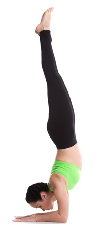

In [174]:
# can be converted easily
img_4 = ch4_pixels[0]
img_bgr = cv2.cvtColor(img_4,cv2.COLOR_BGRA2BGR)
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
plot_color_image(img_rgb)

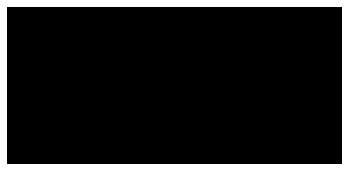

In [176]:
# CANNOT be converted easily
img_4 = cv2.imread('./yoga/child pose/47. 882af92d43b82dd25d4fdfd5e300d79b-child-yoga-pose-silhouette-by-vexels.png',-1)
img_bgr = cv2.cvtColor(img_4,cv2.COLOR_BGRA2BGR)
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
plot_color_image(img_rgb)

Merge a transparent image with another image using `PIL`:

`image_object.paste(image_2, box=None, mask=None)`
- Ref: https://www.geeksforgeeks.org/how-to-merge-a-transparent-png-image-with-another-image-using-pil/

In [224]:
def merge_transparent(front_path,back_path):
    """merge front image with a transparent background
    with a background image(pure color)

    """
    frontImage = Image.open(front_path)
    background = Image.open(back_path) 

    # Convert image to RGBA
    frontImage = frontImage.convert("RGBA")
    background = background.convert("RGBA")

    # images1--image on which the other image is to be pasted--background
    # image_2/source
    # box:opt,4-tuple,if None--source is pasted into upper left corner
    # mask:!! If pass an image with transparency, then the alpha channel is used as the mask.
    background.paste(frontImage,mask=frontImage)
    converted = cv2.cvtColor(np.array(background), cv2.COLOR_RGBA2RGB)
    return converted

In [229]:
white_path = "./images/white.jpg"
for i,img_pixel in enumerate(ch4_pixels):
    img_bgr = cv2.cvtColor(img_pixel,cv2.COLOR_BGRA2BGR)
    img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    if len(np.unique(img_rgb)) == 1: #RGB image only has one value
        front_path = ch4_paths[i]
#         print(f"{i}:{front_path} has transparent background") #下次一定运行这个！
        print(f"{front_path} has transparent background")
        print("Converting...")
        img_rgb = merge_transparent(front_path,white_path)
    
    color_labels.append(ch4_labels[i])
    color_pixels.append(img_rgb)
    color_paths.append(ch4_paths[i])

./yoga/mountain pose/32. 300px-tadasana.png has transparent background
Converting...
./yoga/mountain pose/51. 300px-viparita_namaskar_tadasana.png has transparent background
Converting...
./yoga/child pose/47. 882af92d43b82dd25d4fdfd5e300d79b-child-yoga-pose-silhouette-by-vexels.png has transparent background
Converting...
./yoga/chair pose/35. 200px-utkatasana.png has transparent background
Converting...
./yoga/chair pose/16. chair-pose-600x450.png has transparent background
Converting...


(995, 300, 4)
(851, 300, 4)
(233, 497, 4)
(657, 200, 4)
(398, 208, 4)
Saving figure transparent_background


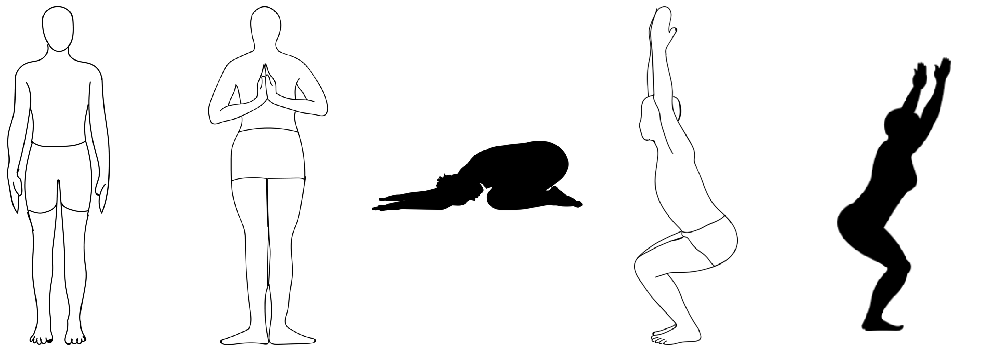

In [240]:
# plot these 5 transparent images
trans_paths = ["./yoga/mountain pose/32. 300px-tadasana.png",
              "./yoga/mountain pose/51. 300px-viparita_namaskar_tadasana.png",
              "./yoga/child pose/47. 882af92d43b82dd25d4fdfd5e300d79b-child-yoga-pose-silhouette-by-vexels.png",
              "./yoga/chair pose/35. 200px-utkatasana.png",
              "./yoga/chair pose/16. chair-pose-600x450.png"]

plt.figure(figsize=(15,5))
for i in range(len(trans_paths)):
    plt.subplot(1,5,i+1)
    transp_img = cv2.imread(trans_paths[i],-1)
    print(transp_img.shape)
    plot_image(transp_img)
save_fig("transparent_background")
plt.show()

In [239]:
# double check
np.where([img_pixel.shape[2] == 4 for img_pixel in color_pixels]) 

#no pixel array still has 4 channels
#np.where return loc index of True value

(array([], dtype=int64),)

### Preprocess gray images

(410, 750)
(801, 800)
(447, 450)
Saving figure gray_scale


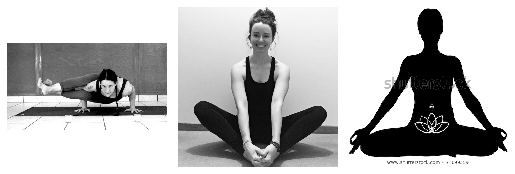

In [242]:
plt.figure(figsize=(12,5))
for i in range(len(gray_pixels)):
    plt.subplot(1,5,i+1)
    print(gray_pixels[i].shape)
    plot_image(gray_pixels[i])
save_fig("gray_scale")
plt.show()

In [243]:
# gray --> RGB
for i,img_pixel in enumerate(gray_pixels):
    img_rgb = cv2.cvtColor(img_pixel,cv2.COLOR_GRAY2RGB)
    color_labels.append(gray_labels[i])
    color_pixels.append(img_rgb)
    color_paths.append(gray_paths[i])

In [251]:
color_pixels[0].dtype

dtype('uint8')

### Change data type
- Convert from `uint8` data type to `float32` data type

In [252]:
# Convert from `uint8` data type to `float32` data type
print(color_pixels[0].dtype)
color_pixels_new = [pixels.astype("float32") for pixels in color_pixels]
print(color_pixels_new[0].dtype)

uint8
float32


In [250]:
print(f"After preprocessing,there are total {len(color_labels)} images")
print(f"There are {len(pose_mapping.keys())} different poses in dataset")

After preprocessing,there are total 5994 images
There are 107 different poses in dataset


# EDA

In [63]:
#utility function to plot grayscale & RGB images
def plot_image(image,title=None,**kwargs):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    plt.title(title,**kwargs)

def plot_color_image(image,title=None,**kwargs):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    plt.title(title,**kwargs)

In [253]:
num_samples = len(color_labels)

## Size/storage

Byte-->MB/GB:
- ref: https://stackoverflow.com/questions/5194057/better-way-to-convert-file-sizes-in-python
- Instead of a size divisor of 1024 * 1024, could use the`<<` bitwise shifting operator

```python
# MB
print(f"{os.path.getsize(filepath)/float(1<<20):,.0f} MB")
# GB
print(f"{os.path.getsize(filepath)/float(1<<30):,.0f} GB")

# 或者用command：
! du -sh {DATA_DIR}
```

In [13]:
!du -sh {data_dir}

1.2G	./yoga


In [14]:
sizes_bytes = [os.path.getsize(image_path) for image_path in images_path]
print(f"Images size:{sum(sizes_bytes)/float(1<<30):.3f} GB")

Images size:1.029 GB


Randomly plot 10 images

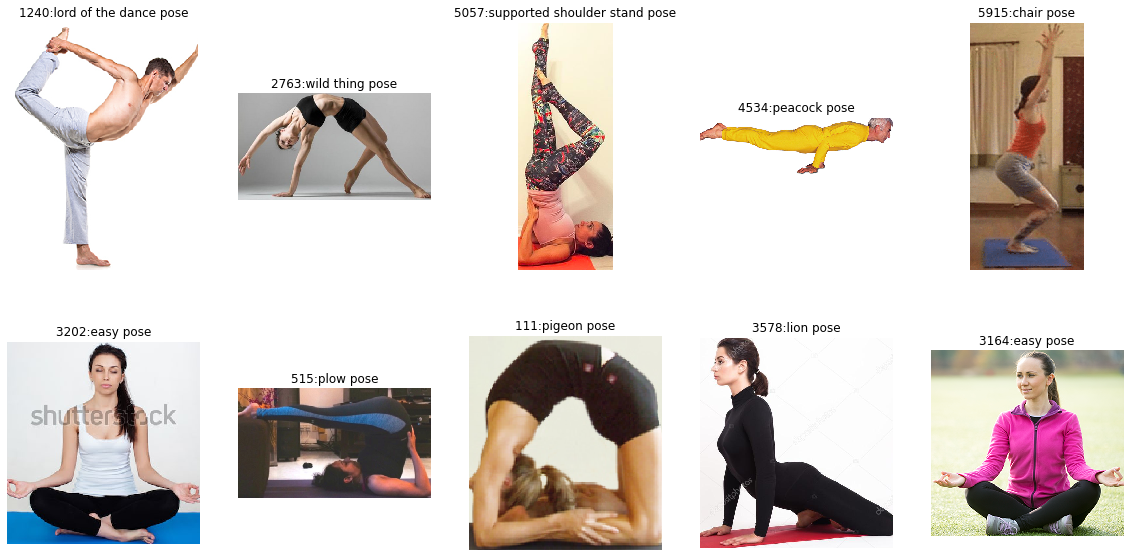

In [320]:
plt.figure(figsize=(20,10))
for idx,i in enumerate(np.random.choice(range(num_samples),size=10,replace=False)):
    img_r = color_pixels[i]
    plt.subplot(2,5,idx+1)
    plot_color_image(img_r,title=f"{i}:{pose_mapping[color_labels[i]]}")
    

## Different Image Processing Techniques
### Image Thresholding(can only be done to gray scale images)
- used to separate foreground image object from background,based on pixel intensities
- **Simple Threholding**:use a **GLOBAL value** as threshold value. 
    - If pixel value is greater than a threshold value, it is assigned one value (may be white), else it is assigned another value (may be black).
    - `cv2.threshold`:`First` argument is the source image, which should be a grayscale image. `Second` argument is the threshold value which is used to classify the pixel values. `Third` argument is the maxVal which represents the value to be given if pixel value is more than (sometimes less than) the threshold value. OpenCV provides different styles of thresholding and it is decided by the `fourth` parameter of the function. Different types are:
        - `cv2.THRESH_BINARY,cv2.THRESH_BINARY_INV,cv2.THRESH_TRUNC,cv2.THRESH_TOZERO,cv2.THRESH_TOZERO_INV`

        
- **Otsu's thresholding**(也是global): 
    - In global thresholding, we used an arbitrary value for threshold value--trial and error
    - bimodal image: an image whose histogram has two peaks. For that image, we can approximately take a value in the middle of those peaks as threshold value-->`Otsu binarization`
    - **automatically** calculates a threshold value from image histogram for a bimodal image. (For images which are not bimodal, binarization won’t be accurate.)
    - 使用：in `cv2.threshold()`:`threshold=0`,pass an extra flag: `cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)`
     
- return: 1st--`retVal`: optimal threshold value returned by Otsu;if not used,same as threshold value you used; 2nd--`threshold image`
     
     
- - **Adaptive Threholding**:
    - used where image has **different lighting conditions in different areas**,better results for images with varying illumination.
    - calculate threshold for a small regions of the image:get different thresholds for different regions of the same image 
- arguments如下:
- `src`: source input image
- `maxValue`: the value to be given if pixel value is more than the threshold value
- `Adaptive Method` - It decides how thresholding value is calculated.
    - `cv2.ADAPTIVE_THRESH_MEAN_C` : threshold value is the mean of neighbourhood area.
    - `cv2.ADAPTIVE_THRESH_GAUSSIAN_C` : threshold value is the **weighted sum of neighbourhood values** where weights are a gaussian window.
- `thresholdType`:见上
- `Block Size`: size of neighbourhood area, must `blockSize % 2 == 1 && blockSize > 1`
- `C`:just a constant which is subtracted from the mean or weighted mean calculated

下面三个一定不要运行=。=
因为索引值已经变了。。。

Saving figure threshold_diff_lightning


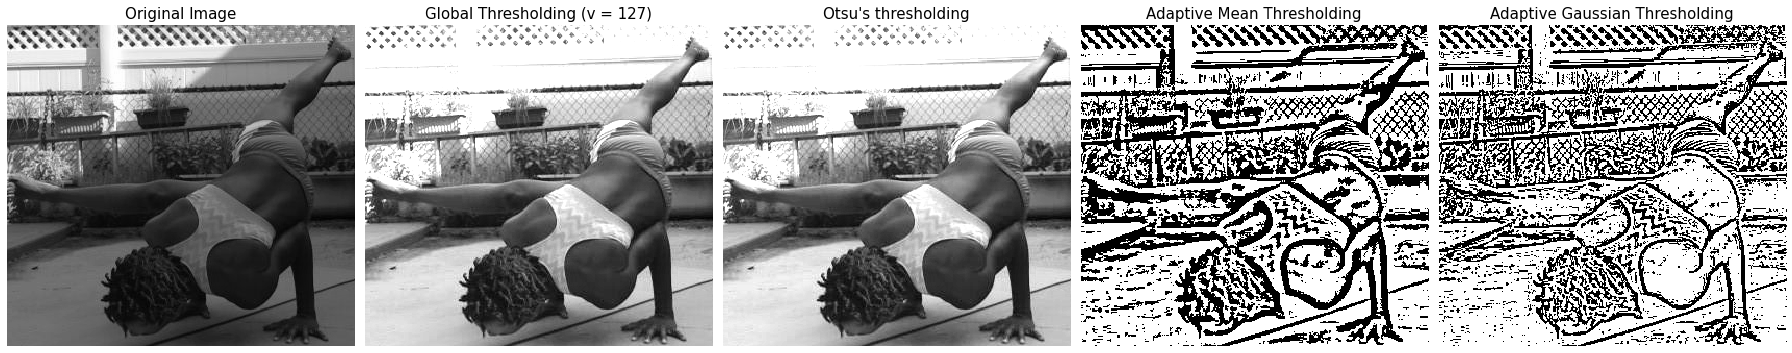

In [277]:
# original images--read in as grayscale
img = cv2.imread(color_paths[2002],0)

# global thresholding with style = THRESH_TRUNC
ret,gthresh_img = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
# Otsu's thresholding--automatically computes the optimal threshold value
ret,othresh_img = cv2.threshold(img,0,255,cv2.THRESH_TRUNC | cv2.THRESH_OTSU)

# adaptive thresholding
athresh1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,13,2)
athresh2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',"Otsu's thresholding",
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img,gthresh_img,othresh_img,athresh1,athresh2]

plt.figure(figsize=(25,8))
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_image(images[i],titles[i],fontsize=15)
save_fig("threshold_diff_lightning")
plt.show()

Saving figure threshold_rm_background


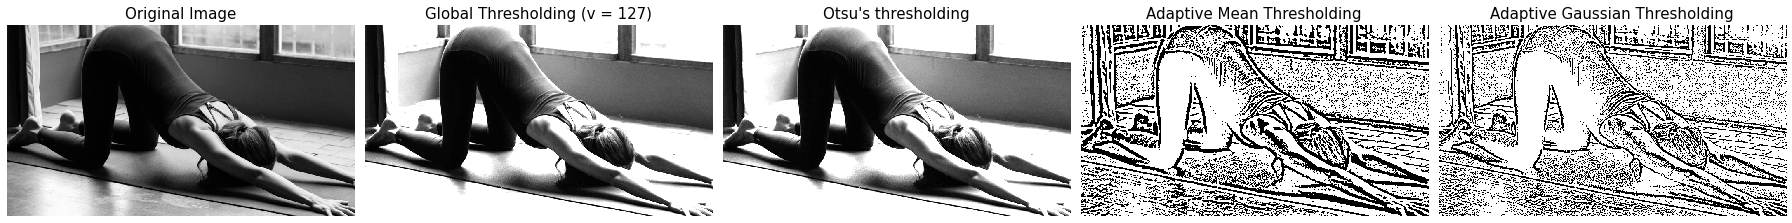

In [314]:
# original images--read in as grayscale
img = cv2.imread(color_paths[3931],0)

# global thresholding with style = THRESH_TRUNC
ret,gthresh_img = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
# Otsu's thresholding--automatically computes the optimal threshold value
ret,othresh_img = cv2.threshold(img,0,255,cv2.THRESH_TRUNC | cv2.THRESH_OTSU)

# adaptive thresholding
athresh1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,13,2)
athresh2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',"Otsu's thresholding",
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img,gthresh_img,othresh_img,athresh1,athresh2]

plt.figure(figsize=(25,8))
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_image(images[i],titles[i],fontsize=15)
save_fig("threshold_rm_background")
plt.show()

Saving figure threshold_emphasize_fore


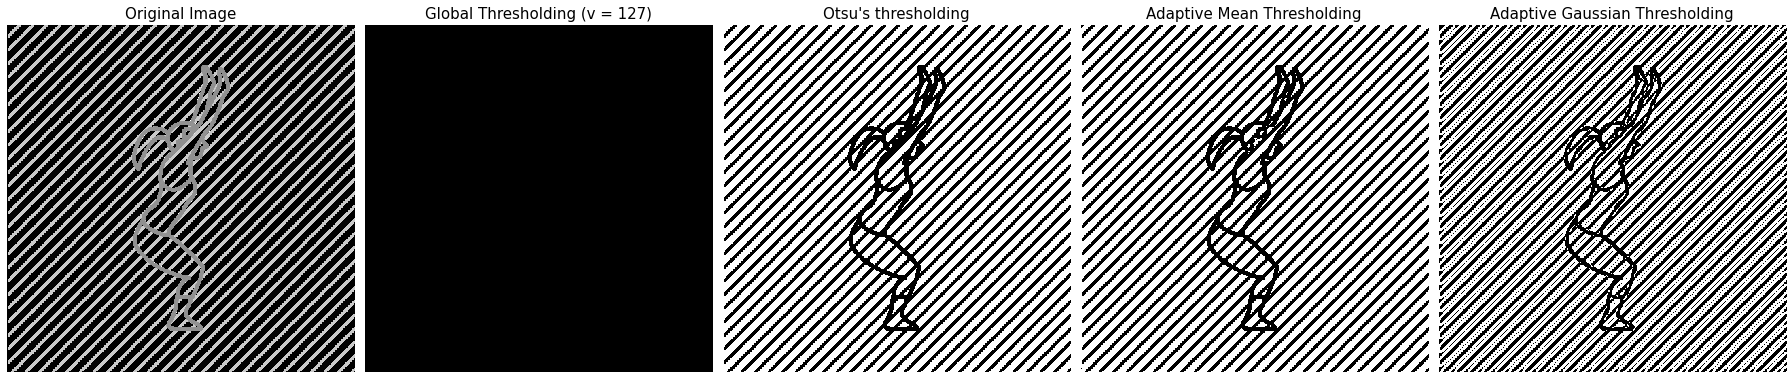

In [123]:
# original images--read in as grayscale
img = cv2.imread(images_path[5496],0)

# global thresholding with style = THRESH_TRUNC
ret,gthresh_img = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
# Otsu's thresholding--automatically computes the optimal threshold value:T=74
ret,othresh_img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# adaptive thresholding
athresh1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,13,2)
athresh2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',"Otsu's thresholding",
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img,gthresh_img,othresh_img,athresh1,athresh2]

plt.figure(figsize=(25,8))
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_image(images[i],titles[i],fontsize=15)
save_fig("threshold_emphasize_fore")
plt.show()

Saving figure threshold_rm_watermark


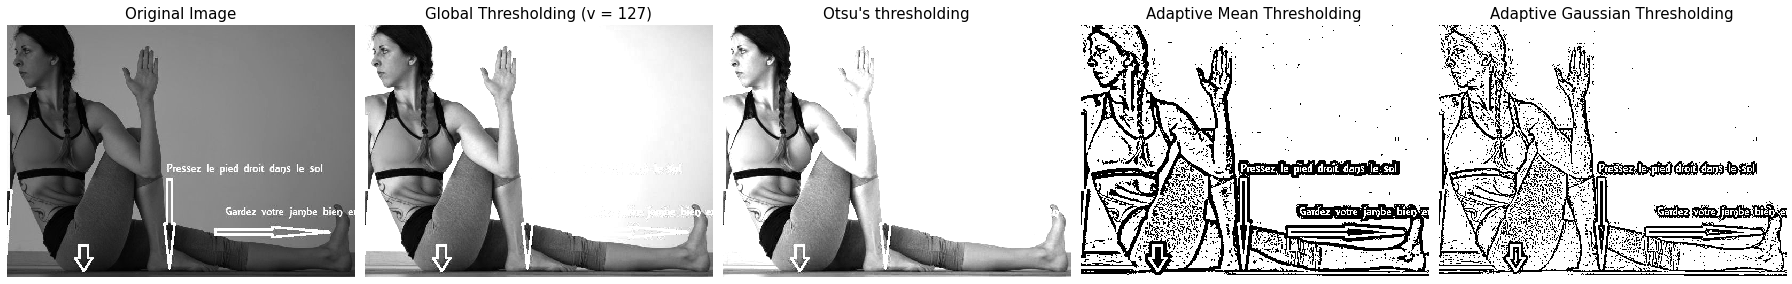

In [110]:
# original images--read in as grayscale
img = cv2.imread(images_path[5055],0)

# global thresholding with style = THRESH_TRUNC
ret,gthresh_img = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
# Otsu's thresholding--automatically computes the optimal threshold value:T=74
ret,othresh_img = cv2.threshold(img,0,255,cv2.THRESH_TRUNC | cv2.THRESH_OTSU)

# adaptive thresholding
athresh1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,13,2)
athresh2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',"Otsu's thresholding",
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img,gthresh_img,othresh_img,athresh1,athresh2]

plt.figure(figsize=(25,8))
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_image(images[i],titles[i],fontsize=15)
save_fig("threshold_rm_watermark")
plt.show()

可以发现即使是different illumination/lightning的图片
- global thresholding is better than adaptive thresholding在背景移除方面 且还有去水印/标记的效果！
    - adaptive使得水印加重了！相当于把watermark也当成foreground object了
    - 且adaptive只能用binary的threshold style作为参数--比较适合黑白图片 not gray scale
- Otsu's thresholding: automatically picked `T` has better effect than manually picked `T` in global thresholding

### 2D Convolution(Image Filtering)
- low-pass filters(LPF): remove noise, blurring image--remove high frequency content(eg: noise,edges)--造成edges也被blurred了（但也有blurring tech不会blur 边缘）
- high-pass filter(HPF):find edges in image

#### Averaging 
- done by convolving the image with a normalized box filter
- takes the average of all the pixels under kernel area and replaces the central element with this average
- `cv2.blur() or cv2.boxFilter()`

#### Gaussian Filtering
- box filter consisting of `equal` filter coefficients
- effective in **removing Gaussian noise** from the image
- `cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType=BORDER_DEFAULT]]] )`
    - std越大&卷积核size越大--blurring效果越好
    - If only sigmaX is specified, sigmaY is taken as equal to sigmaX. If both are given as zeros, they are calculated from the kernel size.

#### Median Filtering
- `cv2.medianBlur()` computes the median of all the pixels under the kernel window and the central pixel is replaced with this median value
- highly effective in removing **salt-and-pepper noise**
- One interesting thing to note is that, in the Gaussian and box filters, the **filtered value for the central element can be a value which may not exist in the original image**. However this is not the case in median filtering, since the **central element is always replaced by some pixel value in the image**. This **reduces the noise effectively**. The kernel size must be a positive **odd integer**.



#### Bilateral Filtering
- `cv2.bilateralFilter()`, is highly effective at noise removal while preserving edges
- 和Gaussian filter的对比：
    - takes the a neighborhood around the pixel and finds its **Gaussian weighted average**
    - is a **function of space alone**：nearby pixels are considered while filtering. 
    - 缺点：It does not consider whether pixels have almost the same intensity value and does not consider whether the pixel lies on an edge or not. The resulting effect is that Gaussian filters tend to blur edges, which is undesirable.

- The bilateral filter **also uses a Gaussian filter in the space domain**, but it also uses one more (multiplicative) Gaussian filter component which is a **function of pixel intensity differences**. The Gaussian function of space makes sure that only pixels are ‘spatial neighbors’ are considered for filtering, while the Gaussian component applied in the intensity domain (a Gaussian function of intensity differences) ensures that **only those pixels with intensities similar to that of the central pixel** (‘intensity neighbors’) are included to compute the blurred intensity value. 
- As a result, this method preserves edges, since for pixels lying near edges, neighboring pixels placed on the other side of the edge, and therefore exhibiting large intensity variations when compared to the central pixel, will not be included for blurring.

Saving figure blurring


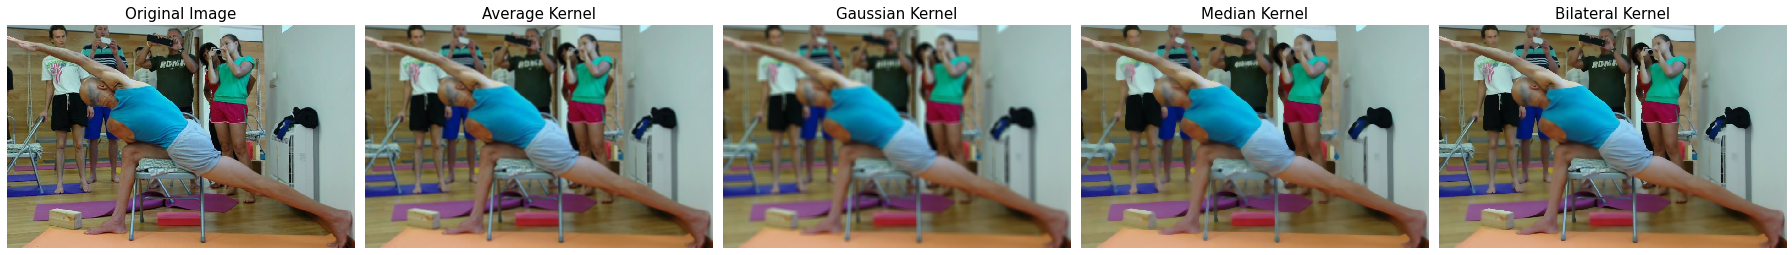

In [305]:
# original image
img = color_pixels[793]

# average filter
avg_blur = cv2.blur(img,(5,5))

# gaussian filter
g_blur = cv2.GaussianBlur(img,(9,9),9)

# median filter
med_blur = cv2.medianBlur(img,9)

# bilateral filtering
bi_blur = cv2.bilateralFilter(img,9,75,75)

titles = ['Original Image', 'Average Kernel',"Gaussian Kernel",
          'Median Kernel', 'Bilateral Kernel']
images = [img,avg_blur,g_blur,med_blur,bi_blur]

plt.figure(figsize=(25,8))
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_image(images[i],titles[i],fontsize=15)
save_fig("blurring")
plt.show()


## Number of images distribution across folders

In [26]:
# 统计每个文件夹有多少张图片
poses = []
imgs = []
for pose in os.listdir(data_dir):
    poses.append(pose)
    pose_dir = os.path.join(data_dir,pose)
    imgs.append(len(os.listdir(pose_dir))) # num of files in each folder 

In [ ]:
# num_poses = len(os.listdir(data_dir))
# df_count = pd.DataFrame(columns=['class','count'])

# df_count["class"] = pd.Series([os.listdir(data_dir)[i] for i in range(num_poses)])
# df_count['count'] = pd.Series([len(os.listdir(os.join(data_dir,os.listdir(data_dir)[i]))) for i in range(num_poses)])

In [27]:
df = pd.DataFrame({"pose":poses,"num_images":imgs})
df.head()

pose  num_images
0                   fish pose          57
1                 pigeon pose          57
2              half frog pose          40
3  standing forward fold pose          63
4     reclined big toe pose a          62

In [28]:
min_pose = df.loc[df["num_images"] == df["num_images"].min()]
max_pose = df.loc[df["num_images"] == df["num_images"].max()]
print("'{0}' has fewest images: {1}".format(min_pose["pose"].values[0],min_pose["num_images"].values[0]))
print("'{0}' has most images: {1}".format(max_pose["pose"].values[0],max_pose["num_images"].values[0]))

'big toe pose' has fewest images: 18
'four-limbed staff pose' has most images: 90


## Top 10 poses

In [29]:
# top 10 poses with most images
top10 = df.sort_values(by="num_images",ascending=False)[:10]

Saving figure top10_poses


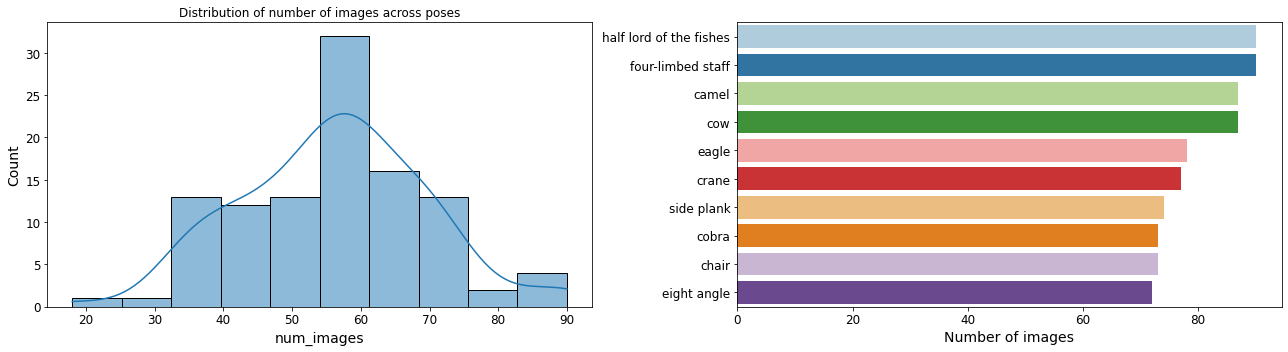

In [37]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
sns.histplot(df["num_images"],bins=10,kde=True,ax=ax1)
ax1.set_title("Distribution of number of images across poses")

sns.barplot(x = top10["num_images"].values,
            y = [name[:-5] for name in top10["pose"].values.tolist()], #ignore " pose" in the end
            orient = "h",palette="Paired",ax=ax2)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels([name[:-5] for name in top10["pose"].values.tolist()])
ax2.set_xlabel('Number of images')
# g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.subplots_adjust(wspace=0.6)
save_fig("top10_poses",tight_layout=True)

- Most yoga poses have number of images from 55 to 60
- Range is from 18 images to 90 images
- class imbalance could be a problem!

In [38]:
top10_labels = top10.merge(label_mapping,on="pose",how="left")["label"].values.tolist()
top10_labels

[76, 63, 67, 19, 79, 70, 46, 84, 97, 34]

In [39]:
# choose 5 random images from each pose label
l_index = {}
for l in top10_labels:
    idx = pd.Series(labels).loc[pd.Series(labels) == l].index.tolist() #extract corresp index for top10 label using T/F Series
    np.random.shuffle(idx) #shuffle in-place
    l_index[l] = np.random.choice(idx,size=5,replace=False).tolist() #sample without replacement

In [30]:
l_index

{76: [4233, 4255, 4283, 4277, 4257],
 63: [3524, 3498, 3467, 3509, 3481],
 67: [3760, 3702, 3748, 3771, 3713],
 19: [1048, 1054, 1037, 1010, 1036],
 79: [4393, 4452, 4435, 4445, 4448],
 70: [3904, 3903, 3922, 3948, 3919],
 46: [2505, 2482, 2484, 2529, 2485],
 84: [4748, 4743, 4691, 4699, 4722],
 97: [5493, 5478, 5519, 5521, 5463],
 34: [1875, 1918, 1873, 1889, 1851]}

Saving figure top10_poses_plot


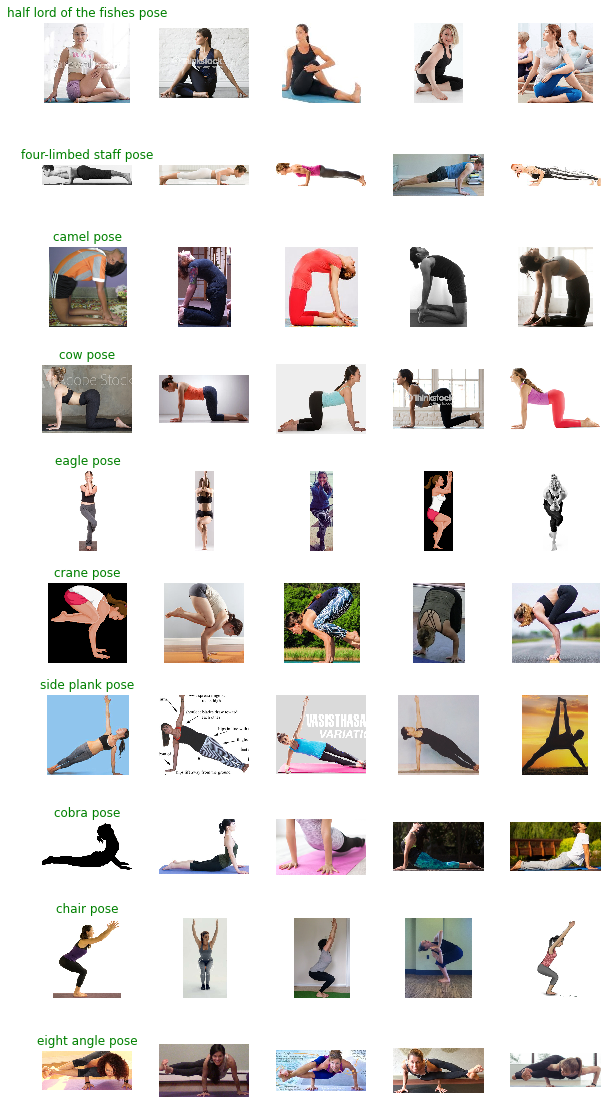

In [40]:
# visualize top10 poses
top_color = "green"
n_rows = 10
n_cols = 5
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row,k in enumerate(l_index.keys()):
    for col,idx in enumerate(l_index[k]):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image = images_pixels[idx]
        plt.imshow(image,interpolation="nearest")
        plt.axis('off')
        if col == 0: 
            plt.title(pose_mapping[k],{"fontsize":12,"color":top_color})
plt.subplots_adjust(wspace=0.3, hspace=0.4)
save_fig('top10_poses_plot', tight_layout=False)
plt.show()

## Least 10 poses
- later in model: may be hard to learn well & classify correctly

In [41]:
bott_10 = df.sort_values(by="num_images",ascending=True)[:10]

bott10_labels = bott_10.merge(label_mapping,on="pose",how="left")["label"].values.tolist()
bott10_labels

[28, 74, 6, 90, 106, 14, 22, 43, 100, 11]

In [42]:
# choose 5 random images from each pose label
l_index = {}
for l in bott10_labels:
    idx = pd.Series(labels).loc[pd.Series(labels) == l].index.tolist() #extract corresp index for top10 label using T/F
    np.random.shuffle(idx) #shuffle in-place
    l_index[l] = np.random.choice(idx,size=5,replace=False).tolist() #sample without replacement

Saving figure bott10_poses_plot


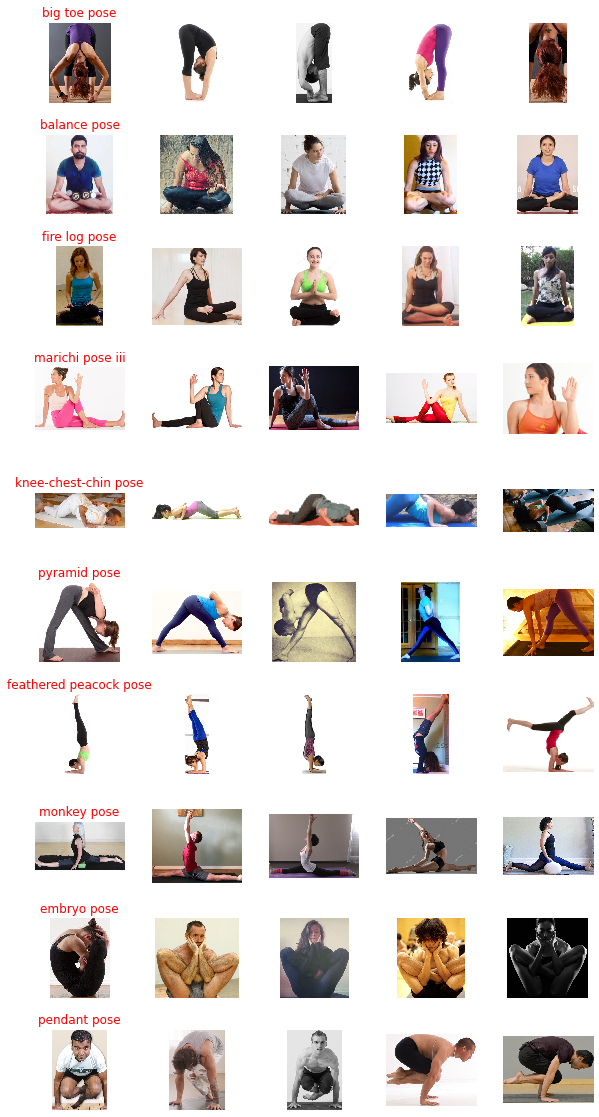

In [44]:
# visualize bottom 10 poses
bt_color = "red"
n_rows = 10
n_cols = 5
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row,k in enumerate(l_index.keys()):
    for col,idx in enumerate(l_index[k]):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image = images_pixels[idx]
        plt.imshow(image,interpolation="nearest")
        plt.axis('off')
        if col == 0: 
            plt.title(pose_mapping[k], {"fontsize":12,"color":bt_color})
plt.subplots_adjust(wspace=0.3, hspace=0.4)
save_fig('bott10_poses_plot', tight_layout=False)
plt.show()

In [42]:
np.unique(np.array([pixel.dtype for pixel in images_pixels])) 
# all images are int8 type

array([dtype('uint8')], dtype=object)

In [49]:
pd.Series([pixel.shape for pixel in images_pixels]).value_counts()

# 5994 images but 5809 different image sizes
# therefore need to resize!

(675, 900, 3)    7
(512, 512, 3)    5
(600, 600, 3)    4
(533, 800, 3)    4
(567, 567, 3)    4
                ..
(481, 833, 3)    1
(348, 639, 3)    1
(232, 306, 3)    1
(258, 298, 3)    1
(259, 518, 3)    1
Length: 5809, dtype: int64

### Further image processing--Enhance image
- Use method **histogram equalization** to enhance image with low contrast, which “spreads out the most frequent intensity values”
- The equalized image has a roughly linear cumulative distribution function.
- Advantage: requires no parameters,but it sometimes yields unnatural looking images. 
- An alternative method is **contrast stretching**, where the image is rescaled to include all intensities that fall within the 2nd and 98th percentiles
- `skimage.exposure.equalize_adapthist`:Contrast Limited **Adaptive Histogram Equalization** (CLAHE).
    - An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.
- Ref: https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html


float64 (278, 383, 3)


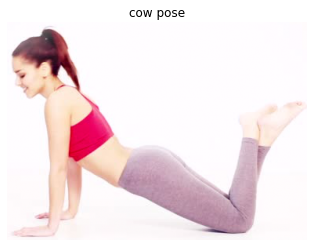

In [150]:
# choose one image to work with
img1 = img_as_float(images_pixels[1020]) #convert uint8-->float64
# o.w hist equalize后的结果都是0-1之间的float
# 如果仍然是int类型 所有pixels会被truncate成0
print(img1.dtype,img1.shape)
plt.imshow(img1)
plt.axis(False)
plt.title(pose_mapping[labels[1020]])
plt.show()

注意：
- 不能改变原始的array！如果将原始array提取出来并直接进行修改 会改变list中的值！
    - eg:[arr1,arr2,arr3] 将arr1提取出来修改 会改变list中的arr1
    
`numpy.rollaxis(a, axis, start=0)`
- 将`axis` roll back到`start`的位置
- 这里是将最后一个(-1)轴---3 channels roll back到第一个位置(0)的位置;相当于变成channel first

In [151]:
# Equalization
img1_equalized = equalize_hist(img1)

In [152]:
# Adaptive Equalization each channel
img1_adap = equalize_adapthist(img1)

In [153]:
# Contrast stretching
p2, p98 = np.percentile(img1, (2, 98))
img1_rescale = rescale_intensity(img1, in_range=(p2, p98))

Saving figure low_contrast


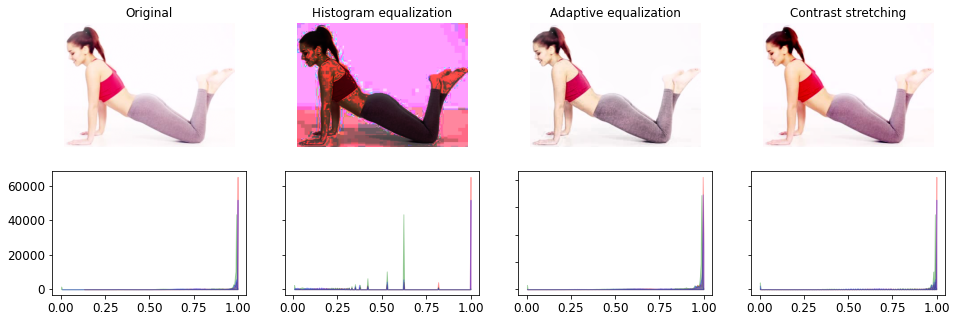

In [161]:
imgs = [img1,img1_equalized,img1_adap,img1_rescale]
titles = ["Original","Histogram equalization","Adaptive equalization","Contrast stretching"]
fig,ax = plt.subplots(2,4,figsize=(16,5))
for i in range(4):
    ax[0,i].imshow(imgs[i])
    ax[0,i].set_title(titles[i])
    ax[0,i].axis('off')
    
    for col, channel in zip('rgb', np.rollaxis(imgs[i], axis=-1)):
        hist, bin_centers = exposure.histogram(channel)
        ax[1,i].fill_between(bin_centers, hist, color=col, alpha=0.3)
        if i != 0:
            ax[1,i].set(yticklabels=[])
save_fig("low_contrast",tight_layout=False)

### Watermark removal trial--further step
以下3种都只能对grayscale image去除，彩色不行！！


Method1: 需要使用额外的image editor来create图片对应的mask image
- 使用Inpainting technique--remove small noises, strokes etc
- Ref: 
    - https://stackoverflow.com/questions/55811122/remove-logo-watermark-given-locations-from-an-image-using-python-opencv-deep-lea
    - https://docs.opencv.org/4.x/df/d3d/tutorial_py_inpainting.html
    
Method2(下面的`back_rm()`):
- Ref: https://stackoverflow.com/questions/32125281/removing-watermark-out-of-an-image-using-opencv

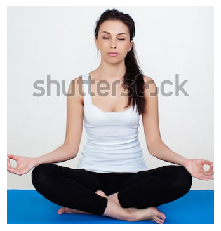

In [321]:
img_water = color_pixels[3202]
plot_color_image(img_water)

In [339]:
def back_rm(img):
    # Load the image
#     img = cv2.imread(filename)

    # Convert the image to grayscale
    gr = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Make a copy of the grayscale image
    bg = gr.copy()

    # Apply morphological transformations
    # approximate the background with watermark
    for i in range(5):
        kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                            (2 * i + 1, 2 * i + 1))
        bg = cv2.morphologyEx(bg, cv2.MORPH_CLOSE, kernel2)
        bg = cv2.morphologyEx(bg, cv2.MORPH_OPEN, kernel2)

    # Subtract the grayscale image from its processed copy
    # difference = background - initial
    dif = cv2.subtract(bg, gr)

    # Apply thresholding
    # threshold the difference image so we get dark letters(actual info)
    bw = cv2.threshold(dif, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # threshold the background image so we get dark region
    dark = cv2.threshold(bg, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Extract pixels in the dark region
    darkpix = gr[np.where(dark > 0)]

    # Threshold the dark region to get the darker pixels inside it
    darkpix = cv2.threshold(darkpix, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Paste the extracted darker pixels in the watermark region
    bw[np.where(dark > 0)] = darkpix.T
    return bw

Saving figure remove_watermark_1


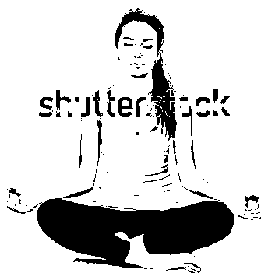

In [340]:
plot_image(back_rm(img_water))
save_fig("remove_watermark_1")

Method3:
- 因为image和watermark有着不同的intensity
- 所以可以通过试图调整`beta`--brightness/`alpha`--contrast until watermark reduce its brightness(vanishes)

Saving figure remove_watermark_2


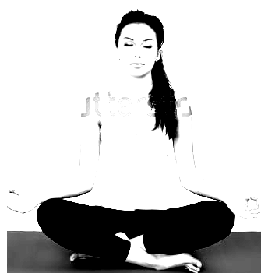

In [341]:
gray = cv2.cvtColor(img_water,cv2.COLOR_RGB2GRAY)
alpha = 3.0
beta = -200

new = alpha * gray + beta
new = np.clip(new, 0, 255).astype(np.uint8)
plot_image(new)
save_fig("remove_watermark_2")